# HW-5
## Sri Hari - Cs19btech11039

### Importing Useful Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import random
import torch
import torchvision
from torch import nn
from torchvision.transforms import ToTensor
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as torch_functions

# load datasets
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=ToTensor())
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=ToTensor())

# Question-1 : CNN feed forward

In [2]:
# class for CNN
# completely implemented as shown in problem statement

class pytorch_NN(nn.Module):
    def __init__(self,dropout=False,value=0,batch_norm=False,batch_value=0):
        super(pytorch_NN,self).__init__()
        self.convolution_1 = nn.Conv2d(1,4,5,1,padding='same')
        self.convolution_2 = nn.Conv2d(4,4,5,1,'same')

        self.hidden = nn.Linear(4*7*7,49)
        self.output = nn.Linear(7*7,10)

        self.dropout = dropout
        self.dropout_value = value

        self.batch_norm = batch_norm
        self.batch_value = batch_value

    def layer1(self,image):
        layer1_ = nn.Sequential(
            self.convolution_1,
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        return layer1_(image)

    def layer2(self,image):
        layer2_ = nn.Sequential(
            self.convolution_2,
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        return layer2_(image)

    def max_pooling(self,image):
        pooler = nn.MaxPool2d(2)
        return pooler(image)

    def get_activation_midway(self,image):
        l1 = self.layer1(image)
        return l1

    def feed_forward(self,image):
        l1 = self.layer1(image)
        l2 = self.layer2(l1)

        x = torch.flatten(l2,1)
        x = self.hidden(x)
        x = torch_functions.relu(x)

        if self.dropout:
            dropout_ = nn.Dropout(self.dropout_value)
            x = dropout_(x)

        if self.batch_norm:
            batchnorm_ = nn.BatchNorm1d(self.batch_value)
            x = batchnorm_(x)

        x = self.output(x)
        x = torch_functions.softmax(x,dim=1)
        return x

# test object
n_ = pytorch_NN()

In [3]:
# dividing 100 images per class
x_train = mnist_trainset.data
y_train = mnist_trainset.targets
x_test = mnist_testset.data
y_test = mnist_testset.targets

train_idx = []
for i in range(0,10):
    condition = np.array(np.argwhere(y_train == i)).reshape(-1)
    indices = condition[:100]
    train_idx.append(indices)
train_idx = np.array(train_idx).reshape(-1)
train_images = x_train[train_idx].reshape([1000,1,28,28]).float()
train_labels = y_train[train_idx]

test_idx = []
for i in range(0,10):
    condition = np.array(np.argwhere(y_test == i)).reshape(-1)
    indices = condition[:10]
    test_idx.append(indices)
test_idx = np.array(test_idx).reshape(-1)
test_images = x_test[test_idx].reshape([100,1,28,28]).float()
test_labels = y_test[test_idx]

In [4]:
# setting optimizers
lr_ = 0.001
# optimizer1 = torch.optim.SGD(n_.parameters(),lr = lr_)
# optimizer2 = torch.optim.SGD(n_.parameters(),lr = lr_,momentum=0.9)
# optimizer3 = torch.optim.RMSprop(n_.parameters(), lr = lr_, alpha=0.9)

## Train and Test methods

In [5]:
loss_fn = nn.CrossEntropyLoss()
batch_size = 100
num_epochs = 25

def test(model,x_test,y_test):
    output = model.feed_forward(x_test)
    y_pred = torch.max(output,1)[1].data.squeeze()
    accuracy = (y_pred == y_test).sum().item()/len(y_test)
    # print(accuracy)
    return accuracy

def train(num_epochs, model, optimizer,display=False):
    epochs = []
    train_errors = []
    test_errors = []
    tsne_util = []

    output = None
    output1 = None
    outputLast = None

    for epoch in range(num_epochs):
        
        temp_images,temp_labels = np.array(train_images),np.array(train_labels)
        zipped = list(zip(temp_images,temp_labels))
        random.shuffle(zipped)
        shuffled_images,shuffled_labels = zip(*zipped)
        shuffled_images = torch.tensor(np.array(shuffled_images))
        shuffled_labels = torch.tensor(np.array(shuffled_labels))

        for i in range(10):
            images = shuffled_images[i*batch_size:(i+1)*batch_size]
            labels = shuffled_labels[i*batch_size:(i+1)*batch_size]
            output = model.feed_forward(images)
            loss = loss_fn(output,labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        if epoch == 0:
            output1 = model.feed_forward(test_images)
        if epoch == num_epochs-1:
            outputLast = model.feed_forward(test_images)

        activation_map = model.get_activation_midway(test_images[0].reshape(1,1,28,28))
        activation_map = np.array(activation_map.detach().numpy()).reshape(14,14,4)
        epochs.append(epoch)
        train_acc = test(model,train_images,train_labels)
        train_errors.append(1-train_acc)
        test_acc = test(model,test_images,test_labels)
        test_errors.append(1-test_acc)
        if display:
            print(f'Epoch - {epoch+1} Train Accuracy : {train_acc} Test Accuracy : {test_acc}')
            plt.imshow(activation_map[:,:,:1].reshape(14,14),cmap='gray')
            plt.show()
    return epochs,train_errors,test_errors,[output1,outputLast]

# epochs,train_errors,test_errors = train(num_epochs,n_,optimizer3)

# Question2 - Using Optimizer Gradients

In [6]:
model1 = pytorch_NN()
optimizer1 = torch.optim.SGD(model1.parameters(),lr = lr_)

model2 = pytorch_NN()
optimizer2 = torch.optim.SGD(model2.parameters(),lr = lr_,momentum=0.9)

model3 = pytorch_NN()
optimizer3 = torch.optim.RMSprop(model3.parameters(), lr = lr_, alpha=0.9)

# Question3 : Observations after each epoch

Model 1
Epoch - 1 Train Accuracy : 0.114 Test Accuracy : 0.1


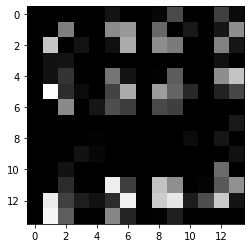

Epoch - 2 Train Accuracy : 0.125 Test Accuracy : 0.11


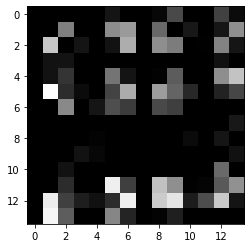

Epoch - 3 Train Accuracy : 0.13 Test Accuracy : 0.11


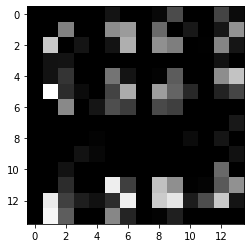

Epoch - 4 Train Accuracy : 0.136 Test Accuracy : 0.11


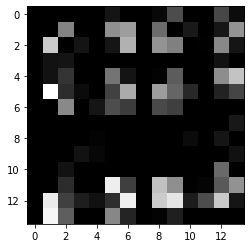

Epoch - 5 Train Accuracy : 0.146 Test Accuracy : 0.11


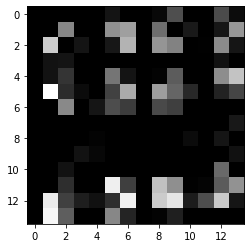

Epoch - 6 Train Accuracy : 0.152 Test Accuracy : 0.12


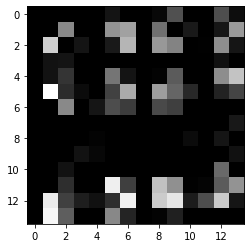

Epoch - 7 Train Accuracy : 0.159 Test Accuracy : 0.13


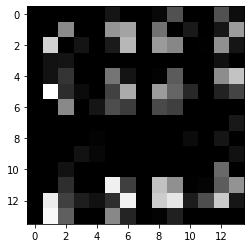

Epoch - 8 Train Accuracy : 0.165 Test Accuracy : 0.13


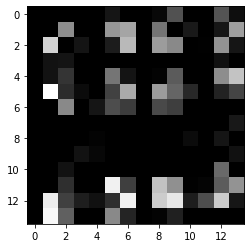

Epoch - 9 Train Accuracy : 0.171 Test Accuracy : 0.13


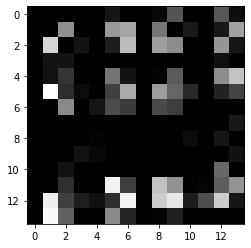

Epoch - 10 Train Accuracy : 0.174 Test Accuracy : 0.13


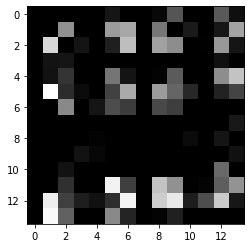

Epoch - 11 Train Accuracy : 0.176 Test Accuracy : 0.14


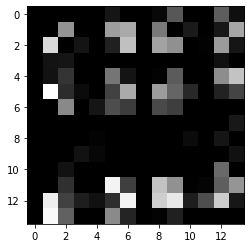

Epoch - 12 Train Accuracy : 0.178 Test Accuracy : 0.14


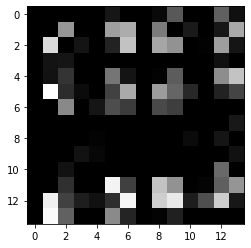

Epoch - 13 Train Accuracy : 0.185 Test Accuracy : 0.13


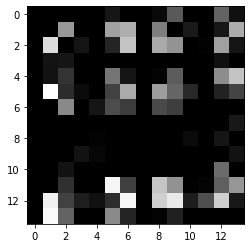

Epoch - 14 Train Accuracy : 0.189 Test Accuracy : 0.14


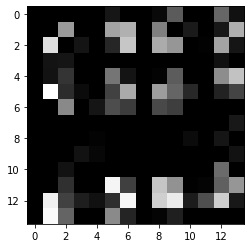

Epoch - 15 Train Accuracy : 0.192 Test Accuracy : 0.15


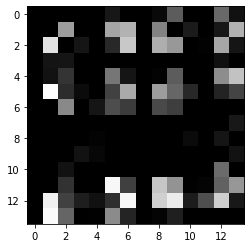

Epoch - 16 Train Accuracy : 0.198 Test Accuracy : 0.16


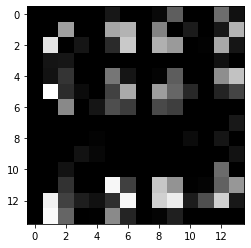

Epoch - 17 Train Accuracy : 0.201 Test Accuracy : 0.18


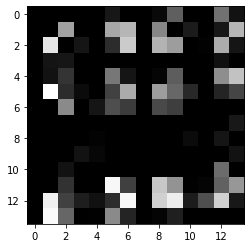

Epoch - 18 Train Accuracy : 0.204 Test Accuracy : 0.19


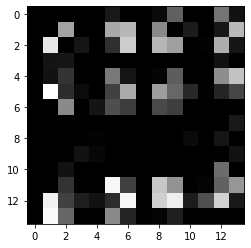

Epoch - 19 Train Accuracy : 0.209 Test Accuracy : 0.19


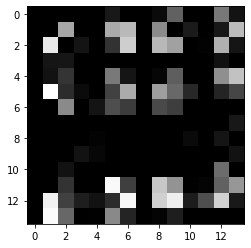

Epoch - 20 Train Accuracy : 0.217 Test Accuracy : 0.19


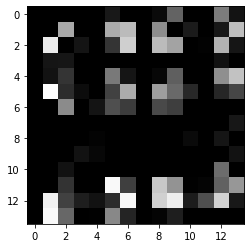

Epoch - 21 Train Accuracy : 0.227 Test Accuracy : 0.19


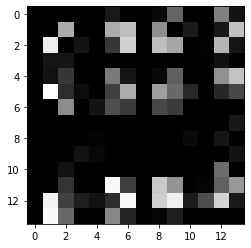

Epoch - 22 Train Accuracy : 0.233 Test Accuracy : 0.19


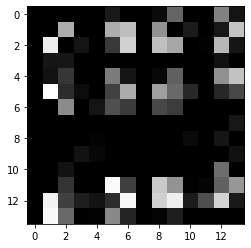

Epoch - 23 Train Accuracy : 0.236 Test Accuracy : 0.19


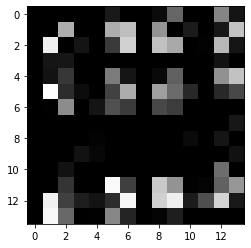

Epoch - 24 Train Accuracy : 0.24 Test Accuracy : 0.19


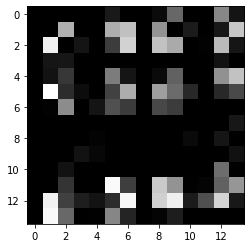

Epoch - 25 Train Accuracy : 0.243 Test Accuracy : 0.2


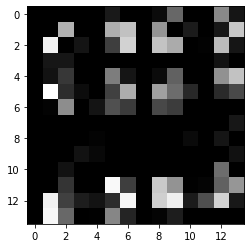

Model 2
Epoch - 1 Train Accuracy : 0.192 Test Accuracy : 0.18


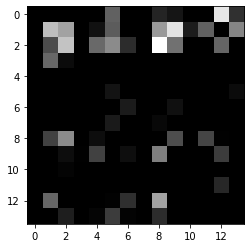

Epoch - 2 Train Accuracy : 0.202 Test Accuracy : 0.21


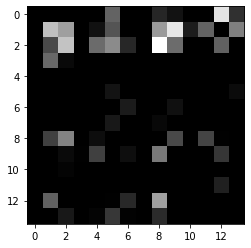

Epoch - 3 Train Accuracy : 0.286 Test Accuracy : 0.28


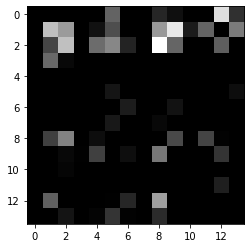

Epoch - 4 Train Accuracy : 0.358 Test Accuracy : 0.32


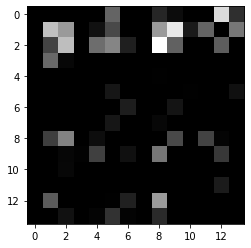

Epoch - 5 Train Accuracy : 0.406 Test Accuracy : 0.36


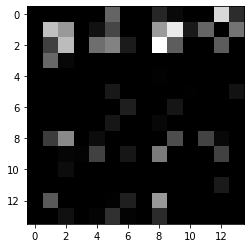

Epoch - 6 Train Accuracy : 0.427 Test Accuracy : 0.41


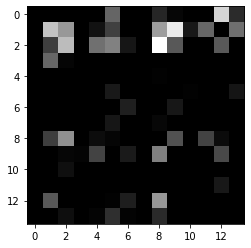

Epoch - 7 Train Accuracy : 0.451 Test Accuracy : 0.43


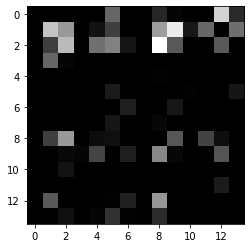

Epoch - 8 Train Accuracy : 0.461 Test Accuracy : 0.42


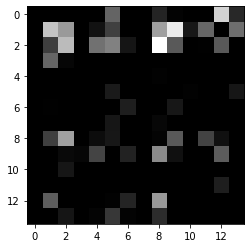

Epoch - 9 Train Accuracy : 0.463 Test Accuracy : 0.45


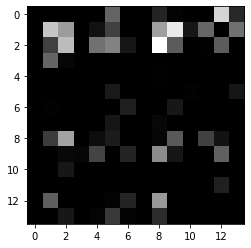

Epoch - 10 Train Accuracy : 0.466 Test Accuracy : 0.45


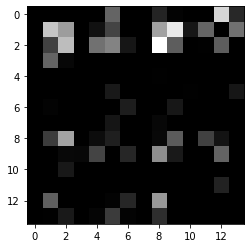

Epoch - 11 Train Accuracy : 0.469 Test Accuracy : 0.45


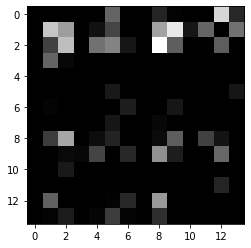

Epoch - 12 Train Accuracy : 0.471 Test Accuracy : 0.46


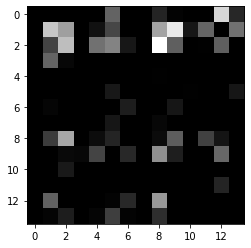

Epoch - 13 Train Accuracy : 0.472 Test Accuracy : 0.47


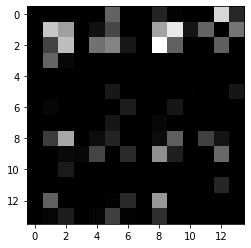

Epoch - 14 Train Accuracy : 0.475 Test Accuracy : 0.46


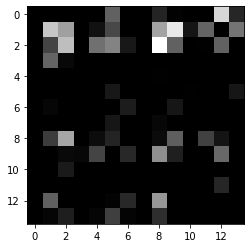

Epoch - 15 Train Accuracy : 0.473 Test Accuracy : 0.46


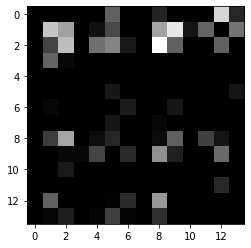

Epoch - 16 Train Accuracy : 0.477 Test Accuracy : 0.48


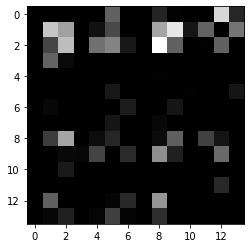

Epoch - 17 Train Accuracy : 0.476 Test Accuracy : 0.47


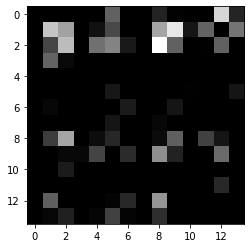

Epoch - 18 Train Accuracy : 0.48 Test Accuracy : 0.48


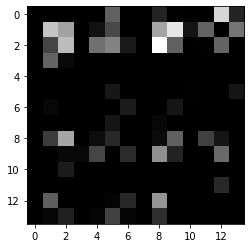

Epoch - 19 Train Accuracy : 0.479 Test Accuracy : 0.47


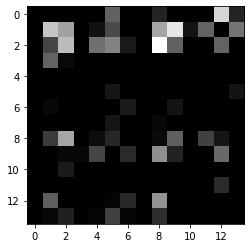

Epoch - 20 Train Accuracy : 0.48 Test Accuracy : 0.48


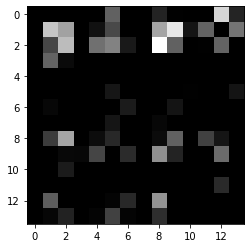

Epoch - 21 Train Accuracy : 0.484 Test Accuracy : 0.47


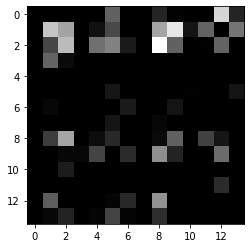

Epoch - 22 Train Accuracy : 0.484 Test Accuracy : 0.47


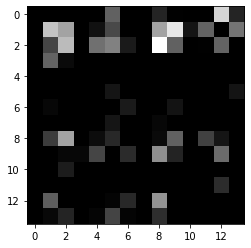

Epoch - 23 Train Accuracy : 0.485 Test Accuracy : 0.47


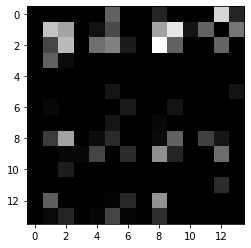

Epoch - 24 Train Accuracy : 0.485 Test Accuracy : 0.46


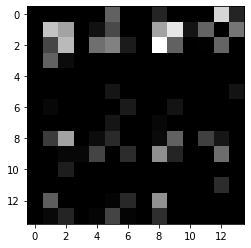

Epoch - 25 Train Accuracy : 0.485 Test Accuracy : 0.46


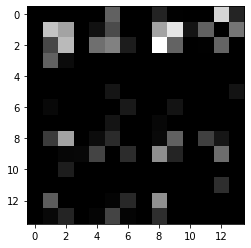

Model 3
Epoch - 1 Train Accuracy : 0.361 Test Accuracy : 0.4


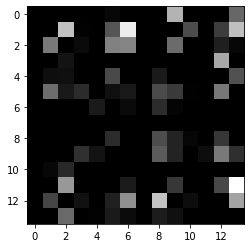

Epoch - 2 Train Accuracy : 0.452 Test Accuracy : 0.43


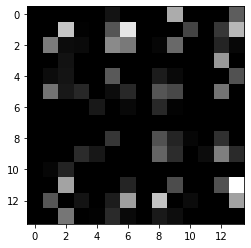

Epoch - 3 Train Accuracy : 0.51 Test Accuracy : 0.49


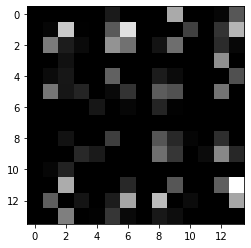

Epoch - 4 Train Accuracy : 0.511 Test Accuracy : 0.47


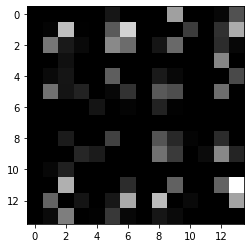

Epoch - 5 Train Accuracy : 0.533 Test Accuracy : 0.5


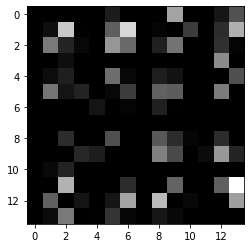

Epoch - 6 Train Accuracy : 0.564 Test Accuracy : 0.55


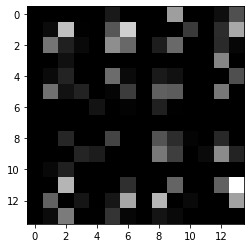

Epoch - 7 Train Accuracy : 0.561 Test Accuracy : 0.55


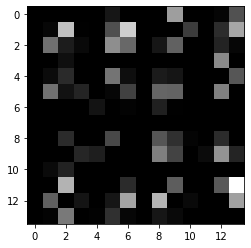

Epoch - 8 Train Accuracy : 0.576 Test Accuracy : 0.54


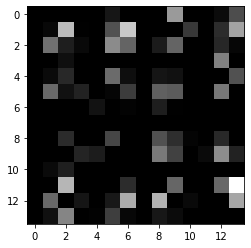

Epoch - 9 Train Accuracy : 0.553 Test Accuracy : 0.54


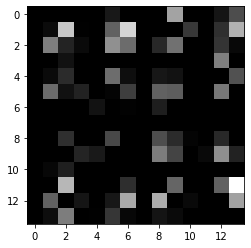

Epoch - 10 Train Accuracy : 0.587 Test Accuracy : 0.56


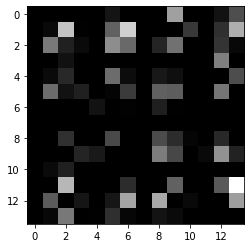

Epoch - 11 Train Accuracy : 0.583 Test Accuracy : 0.58


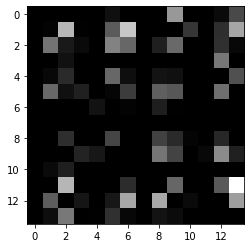

Epoch - 12 Train Accuracy : 0.64 Test Accuracy : 0.58


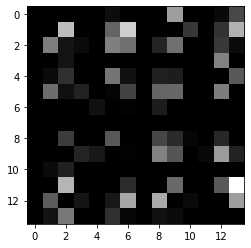

Epoch - 13 Train Accuracy : 0.678 Test Accuracy : 0.65


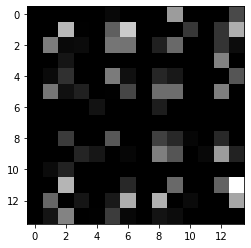

Epoch - 14 Train Accuracy : 0.723 Test Accuracy : 0.68


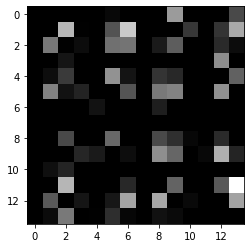

Epoch - 15 Train Accuracy : 0.745 Test Accuracy : 0.69


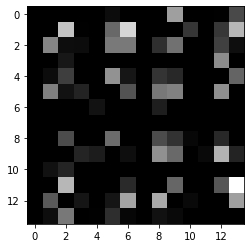

Epoch - 16 Train Accuracy : 0.741 Test Accuracy : 0.68


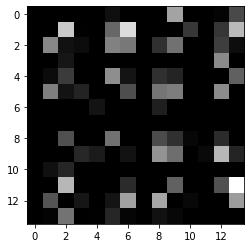

Epoch - 17 Train Accuracy : 0.778 Test Accuracy : 0.78


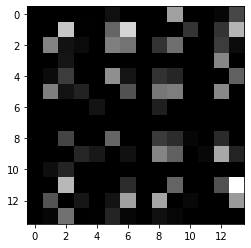

Epoch - 18 Train Accuracy : 0.776 Test Accuracy : 0.73


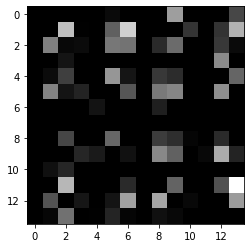

Epoch - 19 Train Accuracy : 0.775 Test Accuracy : 0.75


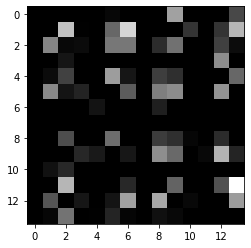

Epoch - 20 Train Accuracy : 0.786 Test Accuracy : 0.76


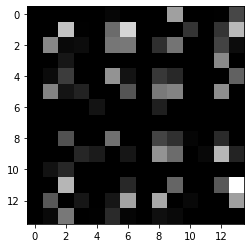

Epoch - 21 Train Accuracy : 0.743 Test Accuracy : 0.68


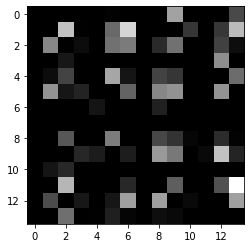

Epoch - 22 Train Accuracy : 0.788 Test Accuracy : 0.76


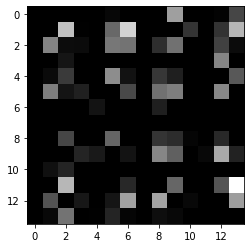

Epoch - 23 Train Accuracy : 0.771 Test Accuracy : 0.75


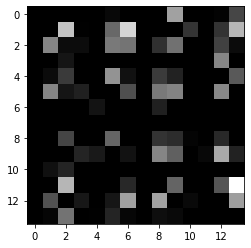

Epoch - 24 Train Accuracy : 0.789 Test Accuracy : 0.77


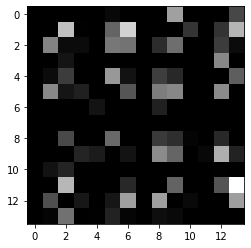

Epoch - 25 Train Accuracy : 0.79 Test Accuracy : 0.74


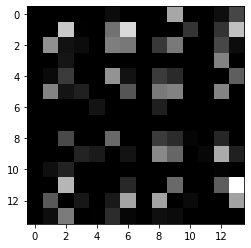

In [7]:
# for vanilla SGD
print('Model 1')
epochs,train_errors_1,test_errors_1,tsne_1data = train(num_epochs,model1,optimizer1,True)

# for SGD with momentum
print('Model 2')
epochs,train_errors_2,test_errors_2,tsne_2data = train(num_epochs,model2,optimizer2,True)

# for RMS prop
print('Model 3')
epochs,train_errors_3,test_errors_3,tsne_3data = train(num_epochs,model3,optimizer3,True)


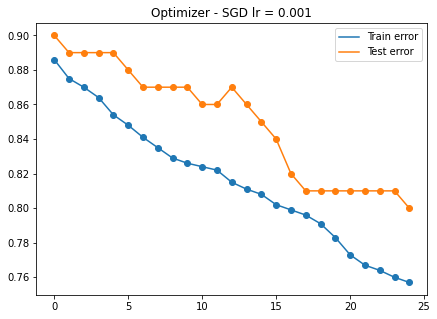

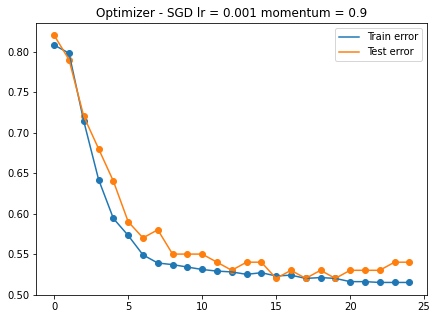

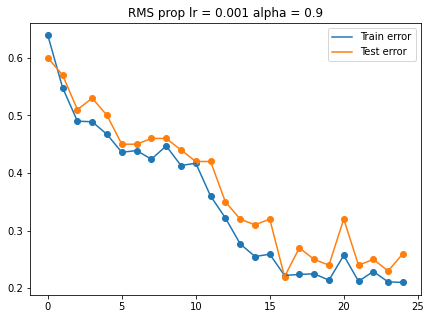

Accuracy for vanilla SGD lr-0.001 :  0.2
Accuracy for vanilla SGD lr-0.001 momentum-0.9 :  0.46
Accuracy for RMS prop lr-0.001 p-0.9 :  0.74


In [8]:
# function to plot graphs
def plot_graphs(epochs,train_errors,test_errors,title_string):
    plt.rcParams["figure.figsize"] = (7,5)
    plt.scatter(epochs,train_errors)
    plt.plot(epochs,train_errors,label='Train error')

    plt.scatter(epochs,test_errors)
    plt.plot(epochs,test_errors,label='Test error')

    plt.title(title_string)
    plt.legend()
    plt.show()

# 3.a
plot_graphs(epochs,train_errors_1,test_errors_1,"Optimizer - SGD lr = 0.001")
plot_graphs(epochs,train_errors_2,test_errors_2,"Optimizer - SGD lr = 0.001 momentum = 0.9")
plot_graphs(epochs,train_errors_3,test_errors_3,"RMS prop lr = 0.001 alpha = 0.9")


# 3.c for each epoch see the above output 
accuracy_1 = test(model1,test_images,test_labels)
accuracy_2 = test(model2,test_images,test_labels)
accuracy_3 = test(model3,test_images,test_labels)

print(f'Accuracy for vanilla SGD lr-0.001 : ',accuracy_1)
print(f'Accuracy for vanilla SGD lr-0.001 momentum-0.9 : ',accuracy_2)
print(f'Accuracy for RMS prop lr-0.001 p-0.9 : ',accuracy_3)


# Question4 : tSNE visualization

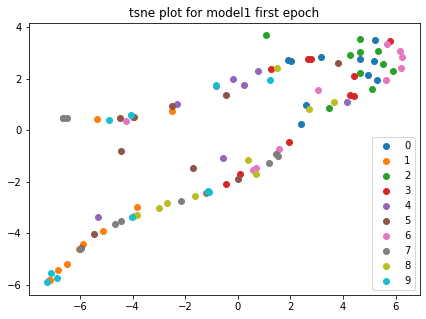

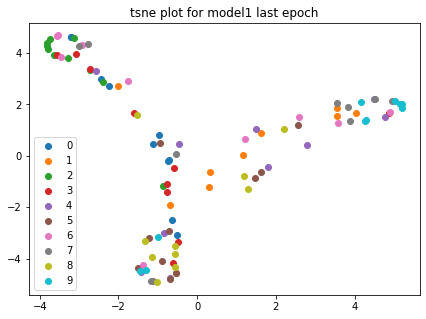

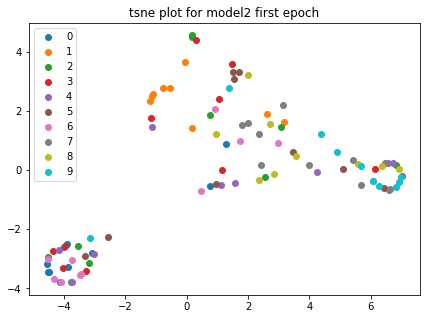

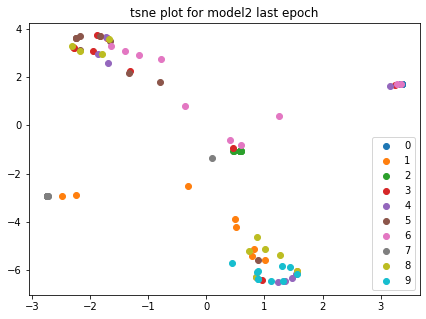

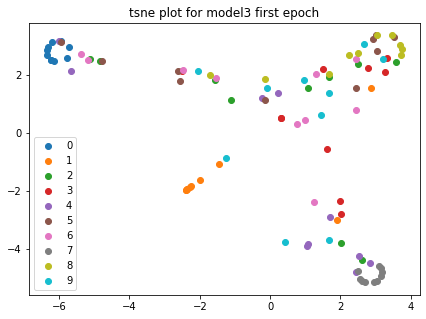

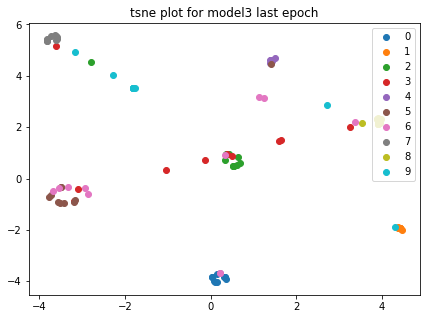

In [9]:
def plot_tsne_graphs(tsne_input,msg):
    plt.rcParams["figure.figsize"] = (7,5)
    tsne_output = TSNE(n_components=2,n_iter=400,init='random',learning_rate='auto',random_state=0).fit_transform(tsne_input[0].detach().numpy())
    labels = {}
    for i in range(len(tsne_output)):
        label = test_labels[i].item()
        if label in labels:
            labels[label].append(tsne_output[i])
        else:
            labels[label] = [tsne_output[i]]
    # print(len(labels.keys()))
    for label_ in labels:
        plt.scatter(np.array(labels[label_])[:,0],np.array(labels[label_])[:,1],label=label_)
    plt.title('tsne plot for '+msg+' first epoch')
    plt.legend()
    plt.show()

    tsne_output = TSNE(n_components=2,n_iter=400,init='random',learning_rate='auto',random_state=0).fit_transform(tsne_input[1].detach().numpy())
    labels = {}
    for i in range(len(tsne_output)):
        label = test_labels[i].item()
        if label in labels:
            labels[label].append(tsne_output[i])
        else:
            labels[label] = [tsne_output[i]]
    for label_ in labels:
        plt.scatter(np.array(labels[label_])[:,0],np.array(labels[label_])[:,1],label=label_)
    plt.title('tsne plot for '+msg+' last epoch')
    plt.legend()
    plt.show()

plot_tsne_graphs(tsne_1data,'model1')
plot_tsne_graphs(tsne_2data,'model2')
plot_tsne_graphs(tsne_3data,'model3')


The graph is showing that RMS prop is well trained.
All the models are training well when comparing the initial and final graphs.

# Question 5 

With comparision, these results are outperforming the results with developed code in last assignment in every aspect.

# Question6 : Experimenting with Drop Out

In [10]:
accuracy_without_drop = test(model3,test_images,test_labels)
print(f'Accuracy without dropout for RMSProp : {accuracy_without_drop}')

dropout_rates = [0.2,0.5,0.8]

for rate in dropout_rates:
    model = pytorch_NN(True,rate)
    optimizer = torch.optim.RMSprop(model.parameters(), lr = lr_, alpha=0.9)
    epochs,train_errors,test_errors,tsne_data = train(num_epochs,model,optimizer)
    accuracy = test(model,test_images,test_labels)
    print(f'Accuracy with dropout-{rate} for RMSprop : {accuracy}')


Accuracy without dropout for RMSProp : 0.74
Accuracy with dropout-0.2 for RMSprop : 0.9
Accuracy with dropout-0.5 for RMSprop : 0.83
Accuracy with dropout-0.8 for RMSprop : 0.51


Upon multiple runs what's observed is for dropout value 0.2 the accuracy is actually increasing, for 0.5 it's almost same and for 0.8 it's dropping by a large margin.

# Question7 : Experimenting with Batch Norm

In [11]:
rate = 0.2
num_epochs = 25
model = pytorch_NN(True,rate,True,49)
optimizer = torch.optim.SGD(model.parameters(),lr = lr_)
train(num_epochs,model,optimizer)

train_accuracy = test(model,train_images,train_labels)
test_accuracy = test(model,test_images,test_labels)
print(f'Train Accuracy with dropout-{rate}, batchnorm-{49} for SGD: {train_accuracy}')
print(f'Test Accuracy with dropout-{rate}, batchnorm-{49} for SGD: {test_accuracy}')

Train Accuracy with dropout-0.2, batchnorm-49 for SGD: 0.196
Test Accuracy with dropout-0.2, batchnorm-49 for SGD: 0.19


Sometimes the dropout and batchnormed model is performing better than the vanilla sgd and some times it is not performing well. Most of the times, this is performing better than vanilla sgd.